```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook reads the data from the rank histogram experiments and
creates the rank histogram.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Rank histogram


This notebook reads the data from the rank histogram experiments and
creates the rank histogram.


## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import os
import sys
import datetime

from importlib import reload
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import IPythonMagic, SimReader, Observation
from SWESimulators import DoubleJetCase
from SWESimulators import DataAssimilationUtils as dautils

In [2]:
%cuda_context_handler gpu_ctx

### Define functions for plotting

In [3]:
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12,3), interior=False):
    fig, axs = plt.subplots(1,3, figsize=figsize)
        
    range_eta = np.max(np.abs(eta))
    range_huv = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    
def plotDrifters(observations, sim_reader, t, ax=None):
    drifter_positions = observations.get_drifter_position(t)

    nx, ny = sim_reader.get('nx'), sim_reader.get('ny')
    dx, dy = sim_reader.get('dx'), sim_reader.get('dy')

    if ax is None:
        fig = plt.figure(figsize=(7,7))
        ax = plt.subplot(111)
        emptyData =np.ma.masked_where(np.zeros((ny,nx)) > 1, np.zeros((ny,nx)))
        ax.imshow(emptyData, origin="lower", extent=[0, nx*dx, 0, ny*dy], cmap='binary')

    for i in range(drifter_positions.shape[0]):
        color = 'xkcd:tomato red'
        circ_end = matplotlib.patches.Circle((drifter_positions[i,0], drifter_positions[i,1]),
                                             3000, fill=True, zorder=10, color=color)
        ax.add_patch(circ_end)

    
def days_to_sec(days):
    return days*24*60*60

def truth_time_step(t):
    t = t - days_to_sec(3)
    return int(t/(60*60))

def file_filter(path_to_dir, ext=None, prefix=None, abspath=True):
    filtered_files = os.listdir(path_to_dir)
    if prefix:
        filtered_files = list(file for file in filtered_files if file.startswith(prefix))
    if ext:
        filtered_files = list(file for file in filtered_files if file.endswith(ext))
    if abspath:
        filtered_files= list(os.path.join(path_to_dir, file)  for file in filtered_files)

    filtered_files.sort()
    return filtered_files

# Reading the truth

Loading the truth to see which parts of the domain that can be relevant. 

We use buoys in order to assimilate the same data points for each round.

In [22]:
truth_path = os.path.abspath('scripts/truth_2019_06_06-09_23_41/')
assert len(os.listdir(truth_path)) == 4, "Truth folder has wrong number of files"

media_dir = '/media/havahol/Seagate Backup Plus Drive/gpu_ocean'

In [23]:
truth_state_filename = os.path.join(truth_path, "double_jet_case_truth.nc")
observations_filename = os.path.join(truth_path, "drifter_observations.pickle")

truth_reader = SimReader.SimNetCDFReader(truth_state_filename)

observation_type = dautils.ObservationType.StaticBuoys
nx = truth_reader.get('nx')
ny = truth_reader.get('ny')
dx = truth_reader.get('dx')
dy = truth_reader.get('dy')
domain_size_x = nx*dx
domain_size_y = ny*dy

observations = Observation.Observation(observation_type=observation_type,
                                       domain_size_x=domain_size_x, domain_size_y=domain_size_y,
                                       nx=nx, ny=ny)
observations.read_pickle(observations_filename)
observations.setBuoyReadingArea('west')

x_index = 100


In [24]:
# Get files
#rank_histogram_paths = [
#    os.path.join(media_dir, 'june_truth/rank_histogram_1_hour/rank_histogram_experiments_2019_06_06-16_40_27/')
#]

dataset = 'june_truth/rank_histogram_72_hour/'
dataset_path = os.path.join(media_dir, dataset)

rank_histogram_time = 72

rank_histogram_paths = list(os.path.join(dataset_path, path) for path in os.listdir(dataset_path))
print(rank_histogram_paths)

rank_histogram_files = []
for path in rank_histogram_paths:
    rank_histogram_files.extend(file_filter(path, 
                                            ext='npz', 
                                            prefix='hour_' + str(rank_histogram_time).zfill(3)))

print(len(rank_histogram_files))

['/media/havahol/Seagate Backup Plus Drive/gpu_ocean/june_truth/rank_histogram_72_hour/rank_histogram_experiments_2019_06_07-16_36_32']
110


In [25]:
# Read the first obtained values
first_experiment = np.load(rank_histogram_files[0])
t_rank = float(first_experiment['t'])
print(t_rank)


518400.0


518400.0 72
(120, 2)
[100   0]
[100  25]
[100  50]
[100  75]
[100 100]
[100 125]
[100 150]
[100 175]
[100 200]
[100 225]
[100 250]
[100 275]


Text(0.5, 1.0, 'at rank hist time, with drifters')

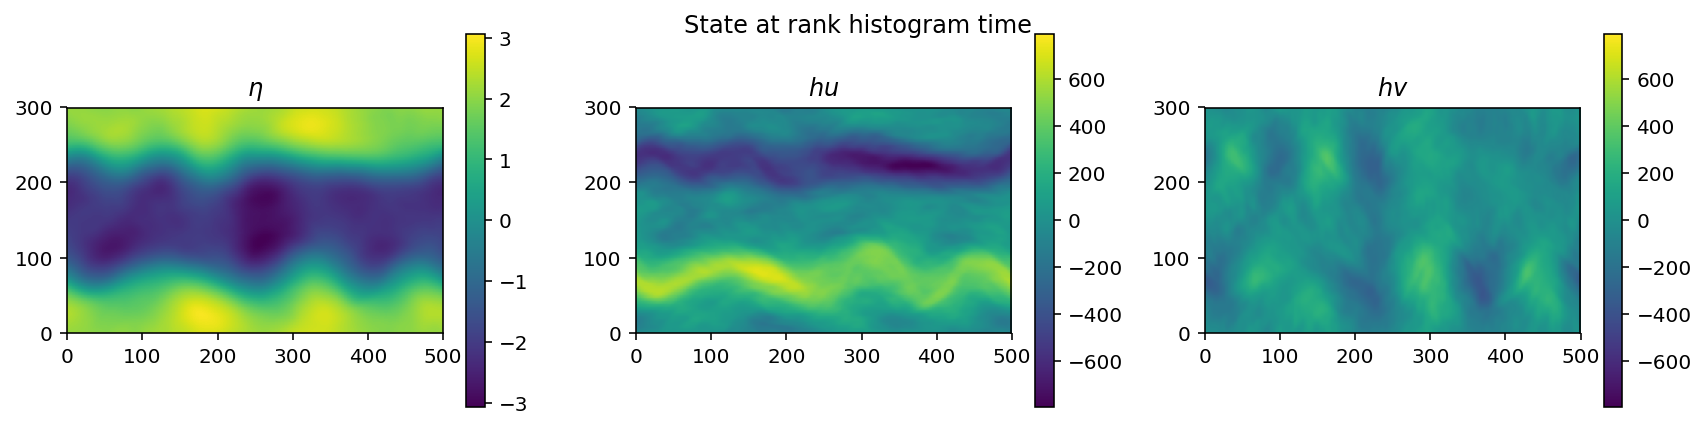

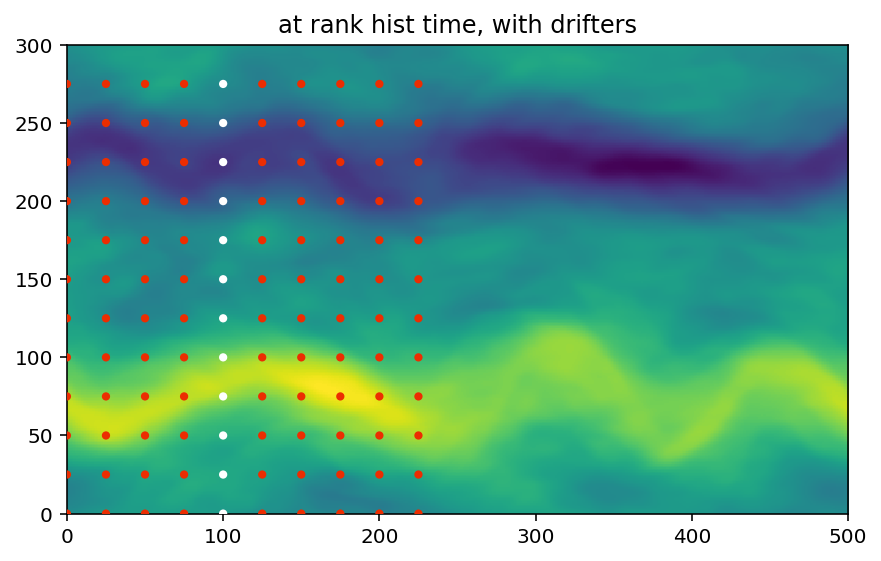

In [26]:
t_rank_index = truth_time_step(t_rank)
eta_rank, hu_rank, hv_rank, t = truth_reader.getTimeStep(t_rank_index)
print(t, t_rank_index)
imshow3(eta_rank, hu_rank, hv_rank, title='State at rank histogram time')

buoy_cell_indices = observations.buoy_indices[observations.read_buoy, :]
print(buoy_cell_indices.shape)

buoy_y = np.zeros(12)
buoy_x = 100
bouy_y_map = [False]*ny

fig = plt.figure(figsize=(7,7))

ax = plt.subplot(111)
ax.imshow(hu_rank, origin="lower", extent=[0, nx, 0, ny])

buoy_index = 0
for i in range(buoy_cell_indices.shape[0]):
    color = 'xkcd:tomato red'
    if buoy_cell_indices[i,0] == buoy_x:
        print(buoy_cell_indices[i,:])
        color = 'xkcd:white'
        buoy_y[buoy_index] = buoy_cell_indices[i,1]
        buoy_index += 1
        bouy_y_map[buoy_cell_indices[i,1]] = True
    circ_end = matplotlib.patches.Circle((buoy_cell_indices[i,0], buoy_cell_indices[i,1]),
                                         2, fill=True, zorder=10, color=color)
    ax.add_patch(circ_end)
    
plt.title('at rank hist time, with drifters')

518400
type of observations.buoy_indices:  int32
direct positions (type float32)
518400.0 72
(120, 4)
[  32.04841232  114.80615234  166.61372375  506.68139648  422.62115479
   74.53134918  -20.50314903  -15.42768478 -301.83920288 -568.84332275
 -295.19299316  -61.3646965 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


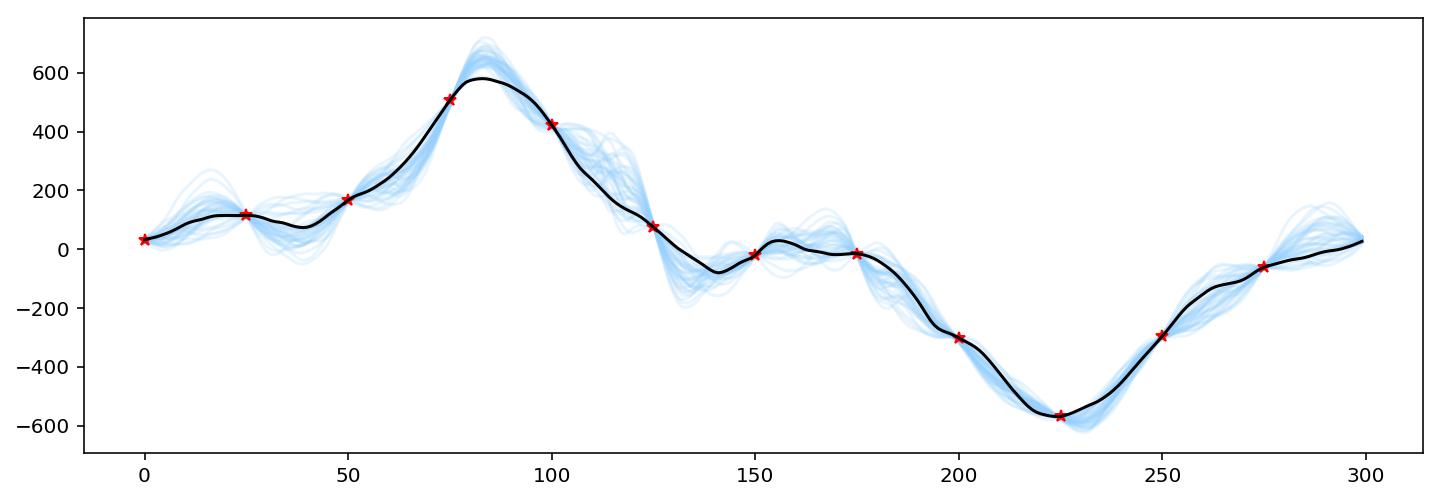

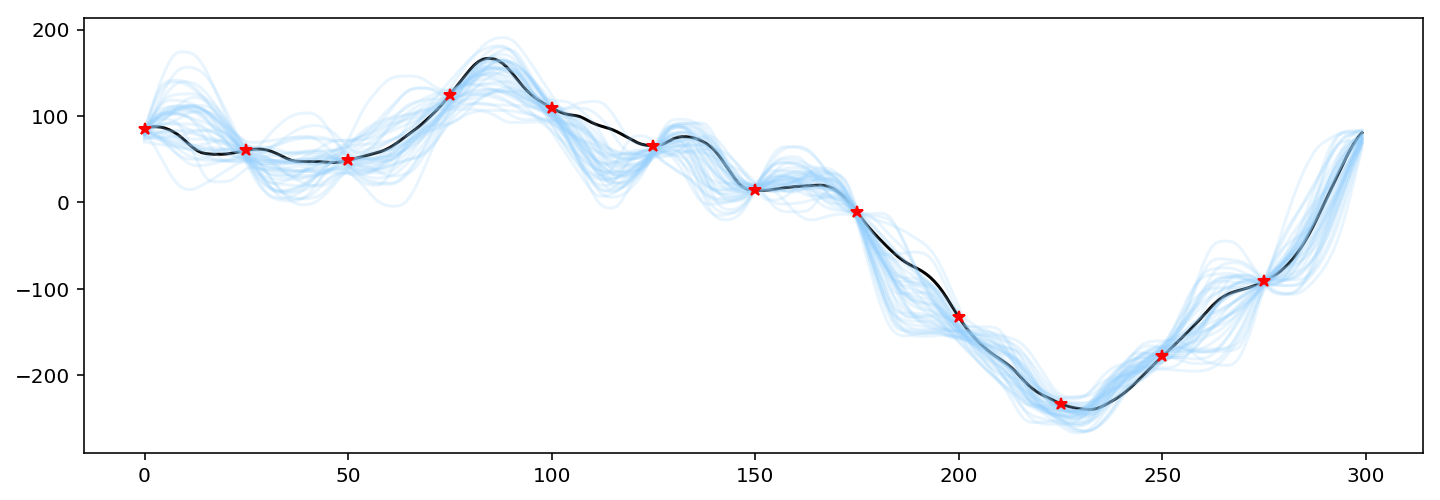

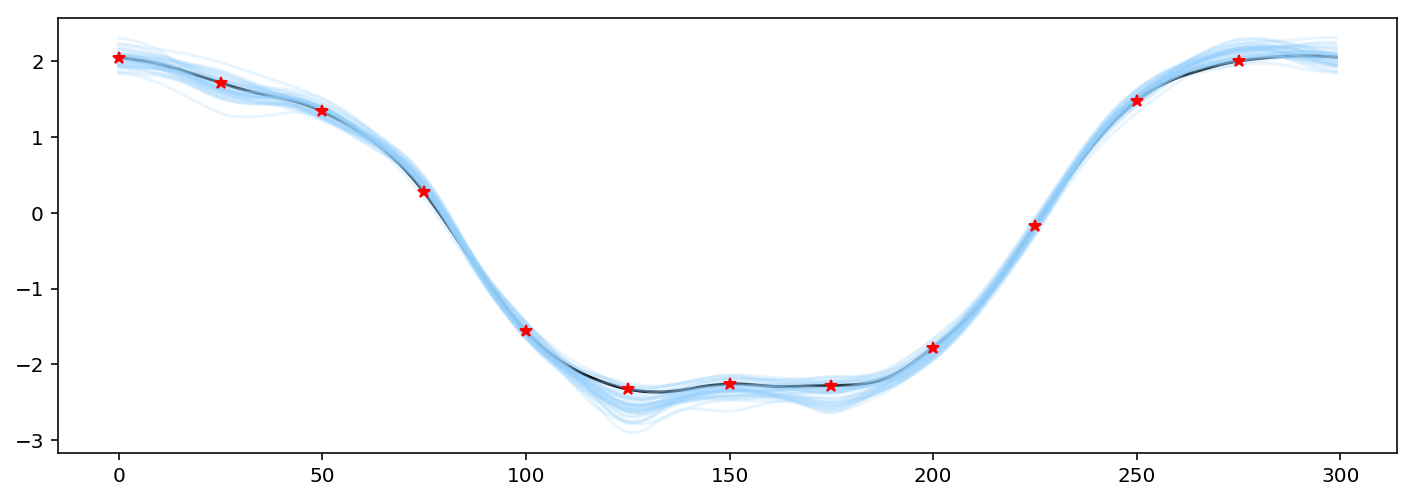

In [27]:
observed_values = observations.get_observation(t_rank, None)

rounded_t = round(t_rank)
t_rank_index_obs = observations.obs_df[observations.obs_df[observations.columns[0]]==rounded_t].index.values[0]

print(rounded_t)
print('type of observations.buoy_indices: ', observations.buoy_indices.dtype)

print('direct positions (type ' + str(observations.buoy_positions.copy()[observations.read_buoy, :].dtype) + ')')
#print(observations.buoy_positions.copy()[observations.read_buoy, :])
#print('direct hu hv:')
#print(observations.obs_df.iloc[index][observations.columns[2]][observations.read_buoy, :])

eta_rank, hu_rank, hv_rank, t = truth_reader.getTimeStep(t_rank_index)
print(t, t_rank_index)

print(observed_values.shape)
print(observed_values[4::10, 2])
print(observed_values[4::10, 2]-hu_rank[bouy_y_map, buoy_x])

# Plotting the cross section at the chosen buoy locations:
fig = plt.figure(figsize=(12,4))
plt.plot(np.arange(ny), hu_rank[:,buoy_x], 'k', zorder=10)
first_hu = first_experiment['hu']
for p in range(first_hu.shape[1]):
    plt.plot(np.arange(ny), first_hu[:,p], color='xkcd:light blue', alpha=0.2)
plt.plot(buoy_y, hu_rank[bouy_y_map, buoy_x], 'r*')


fig = plt.figure(figsize=(12,4))
plt.plot(np.arange(ny), hv_rank[:,buoy_x], 'k')
first_hv = first_experiment['hv']
for p in range(first_hu.shape[1]):
    plt.plot(np.arange(ny), first_hv[:,p], color='xkcd:light blue', alpha=0.2)
plt.plot(buoy_y, hv_rank[bouy_y_map, buoy_x], 'r*')

fig = plt.figure(figsize=(12,4))
plt.plot(np.arange(ny), eta_rank[:,buoy_x], 'k')
first_eta = first_experiment['eta']
for p in range(first_hu.shape[1]):
    plt.plot(np.arange(ny), first_eta[:,p], color='xkcd:light blue', alpha=0.2)
plt.plot(buoy_y, eta_rank[bouy_y_map, buoy_x], 'r*')

# Rank histogram experiment

Rank histograms are an established way to test the quality of data assimilation methods (see reference Hamill 2001 from Skauvold et al). Our rank histogram experiment is based on the buoy experiment in which we observe the western half of the domain with $R = \mathrm{diag}(1)$ and assimilation windows of five minutes.  The ensemble size is sat to $N_e = 40$. For each experiment we store the cross section at $x = 100.5 \Delta x$ (center of the 100'the cell in $x$-direction).

Creating rank histogram from 110 files
.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..100..101..102..103..104..105..106..107..108..109.

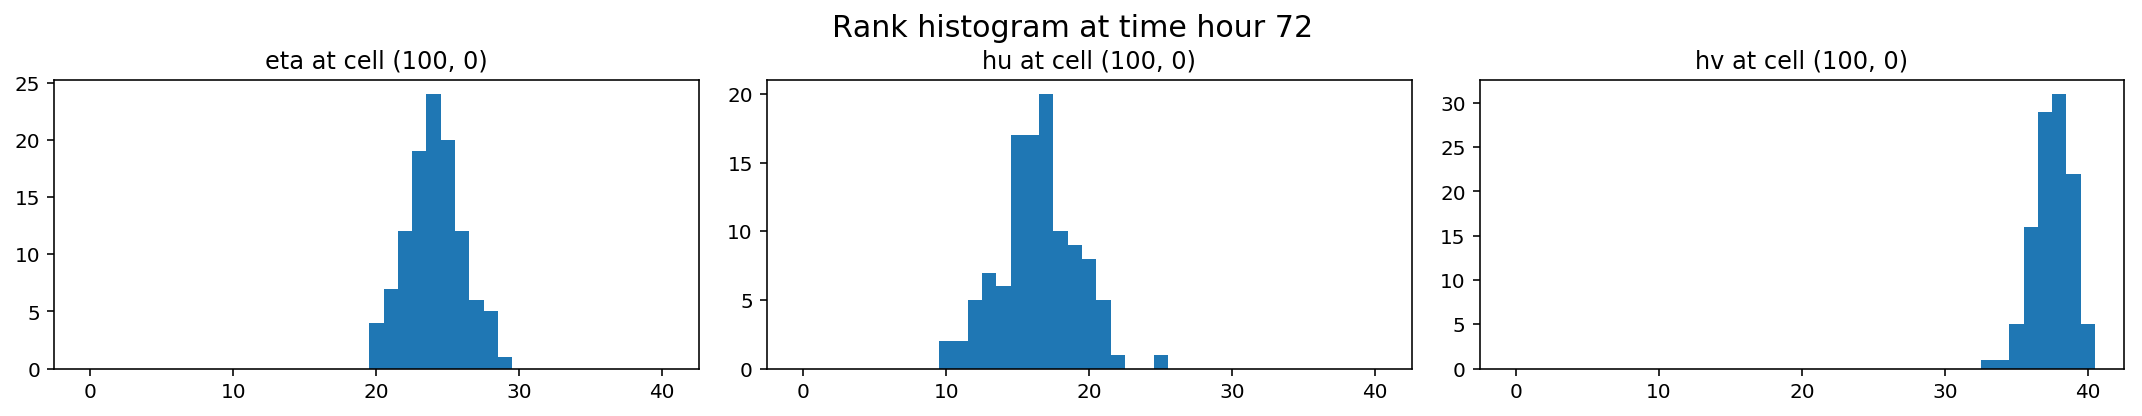

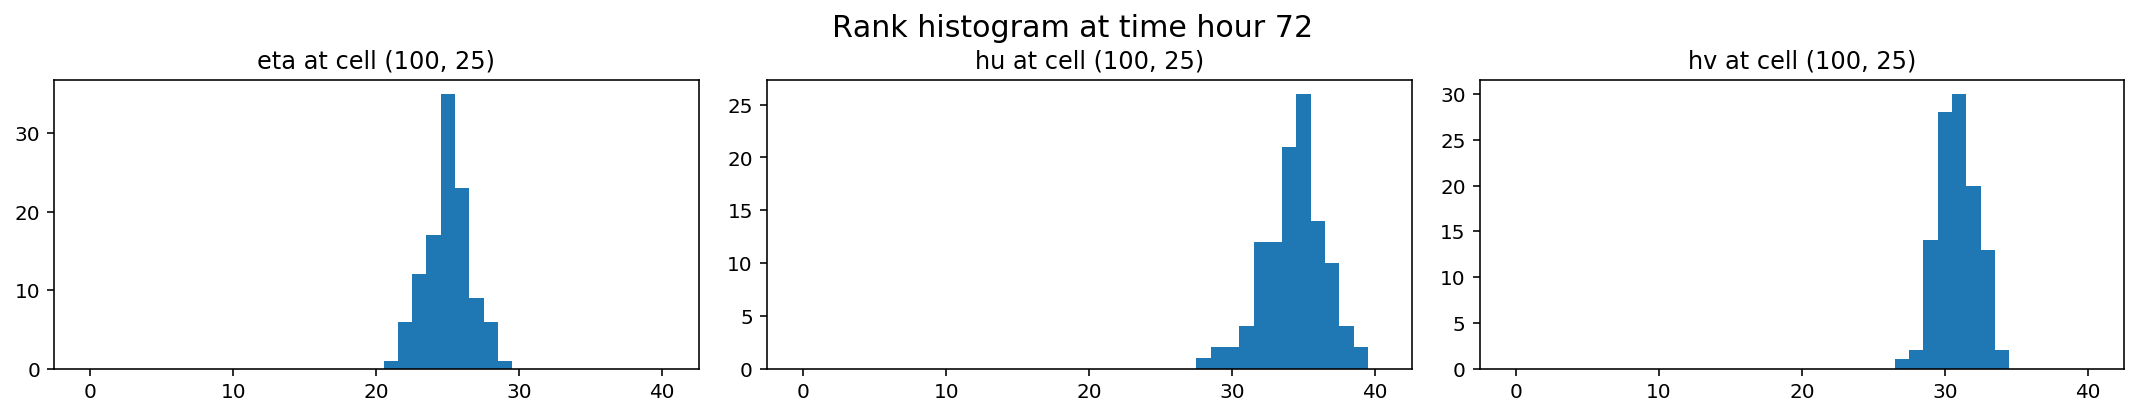

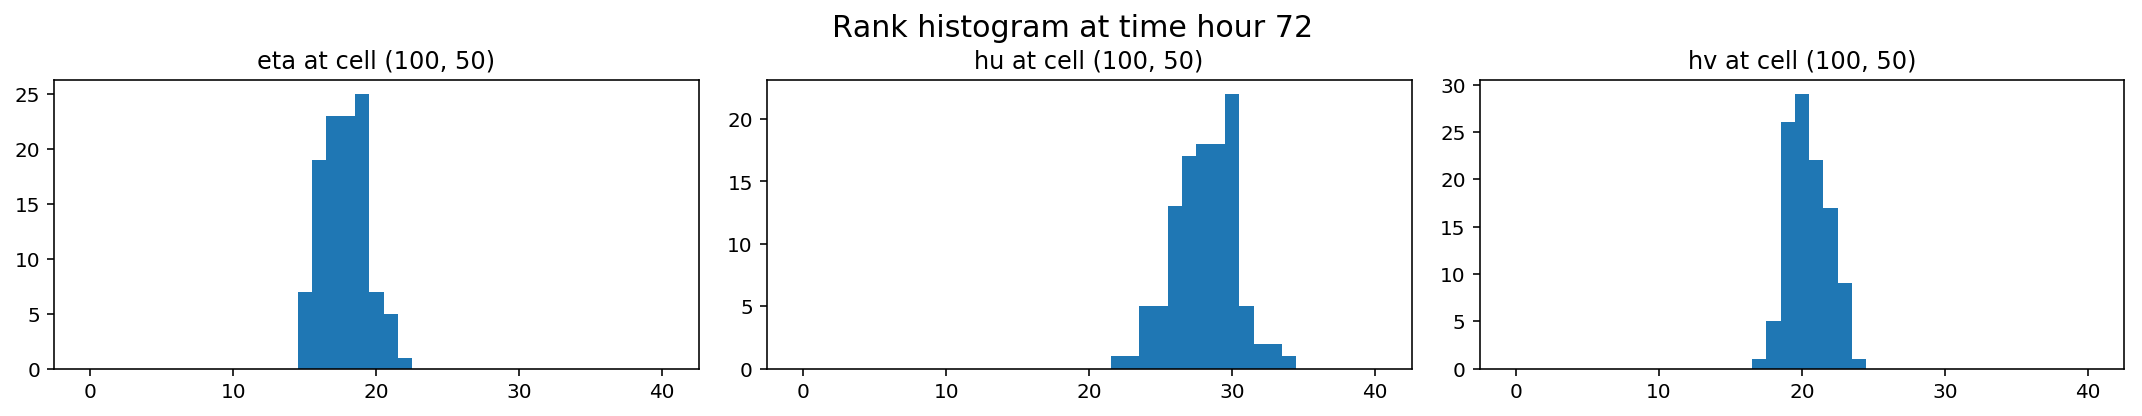

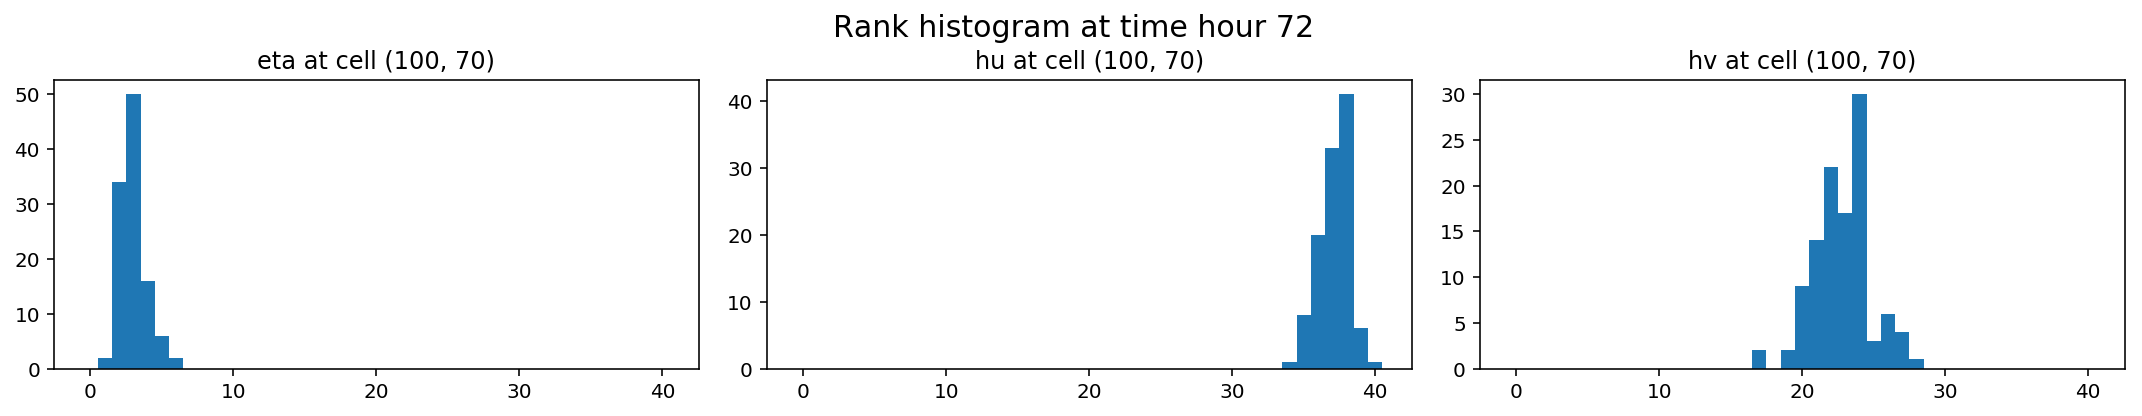

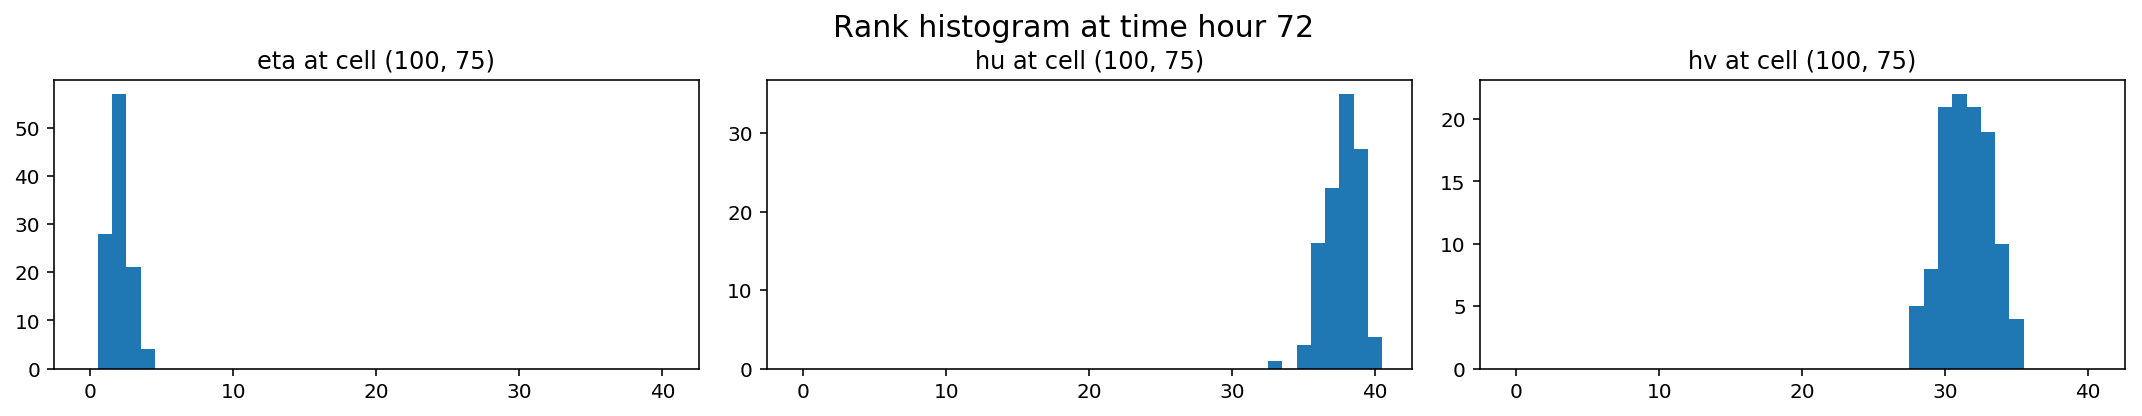

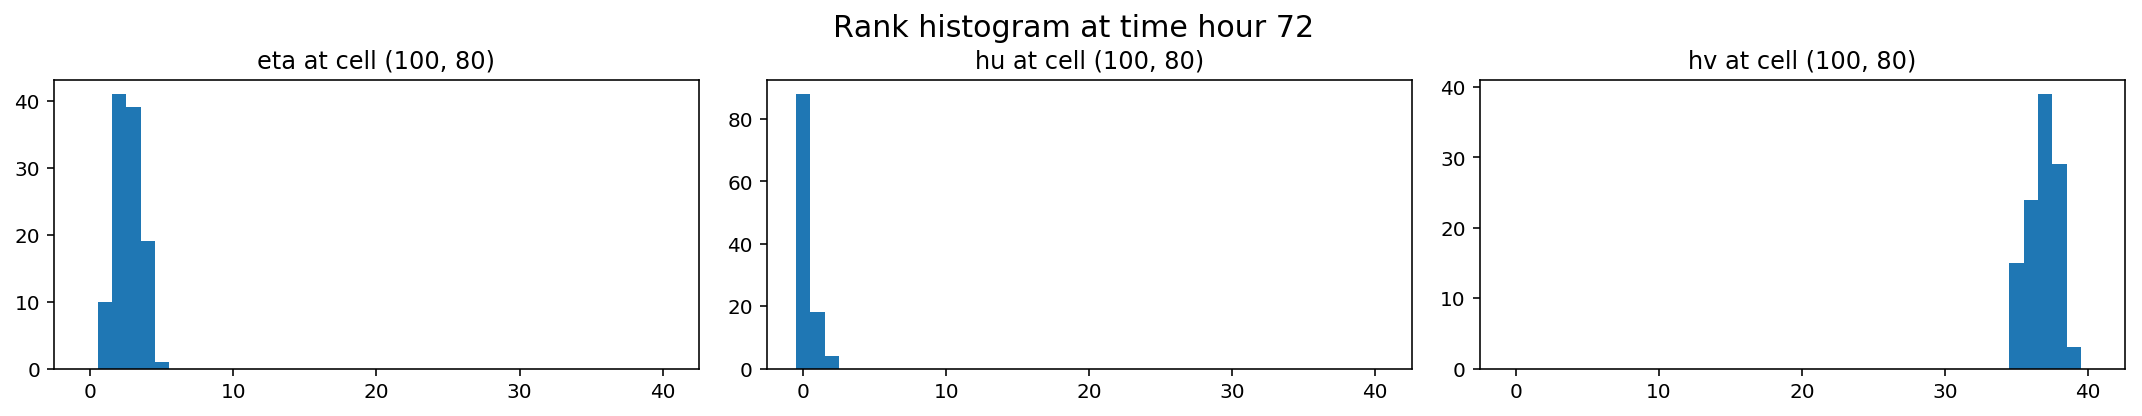

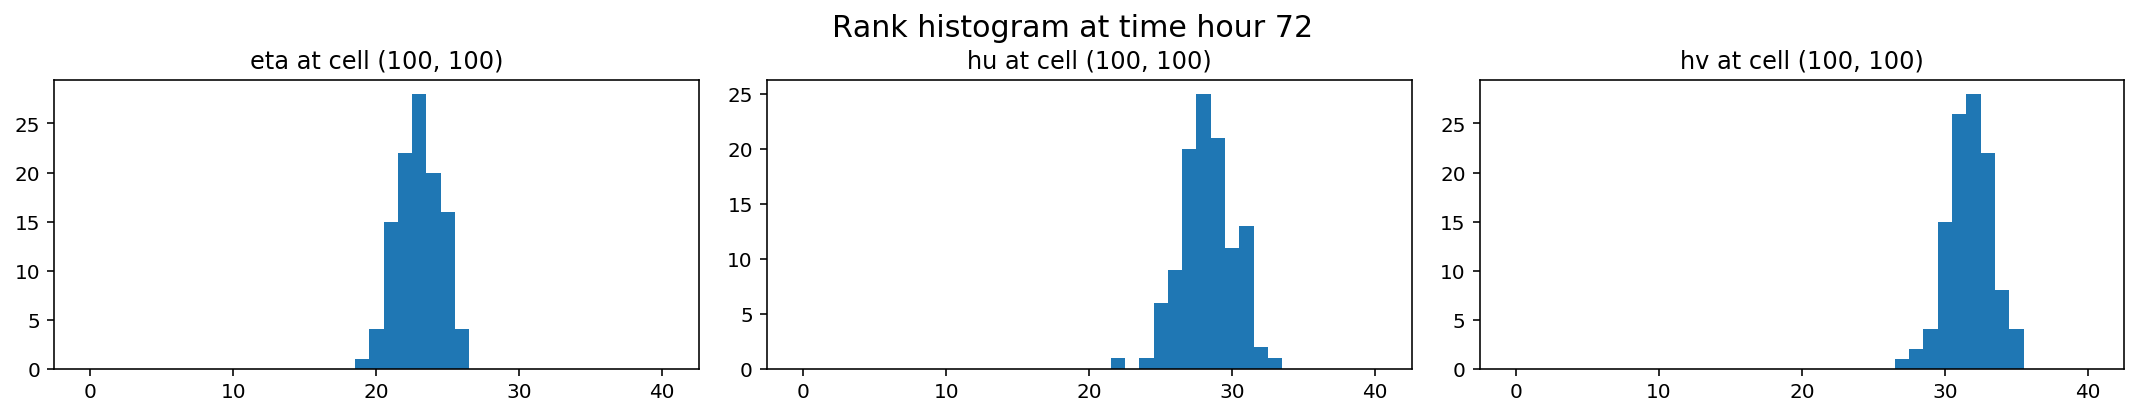

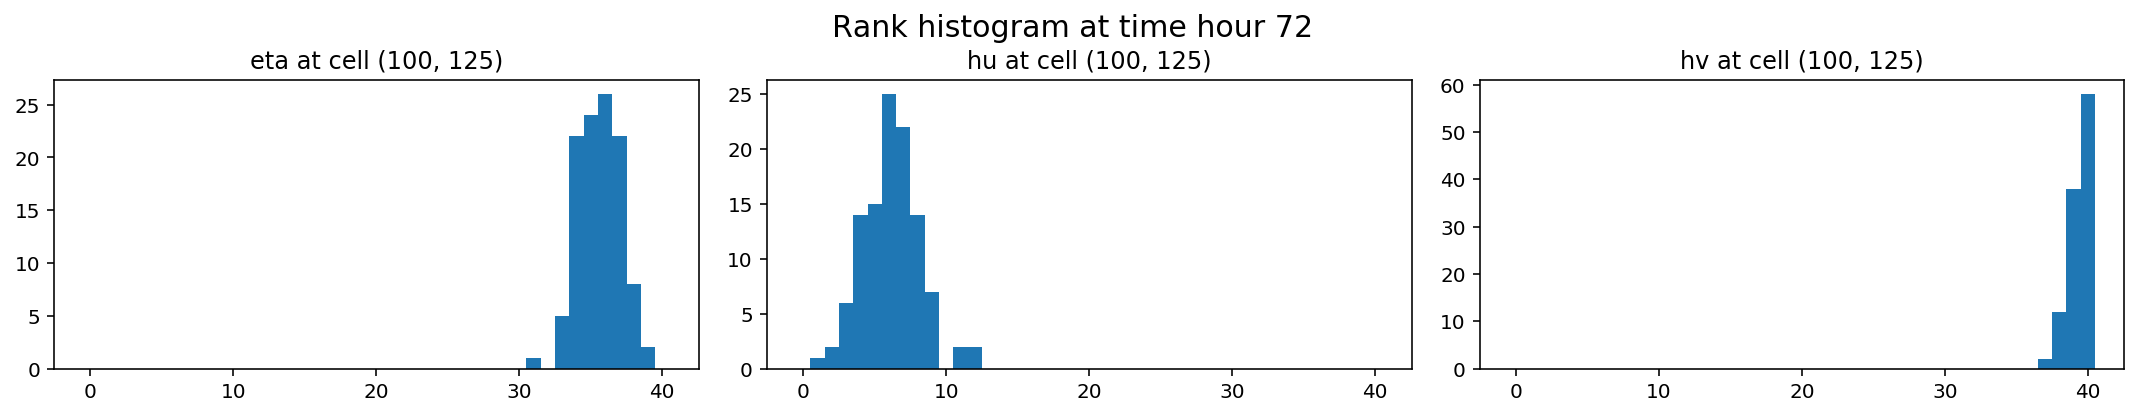

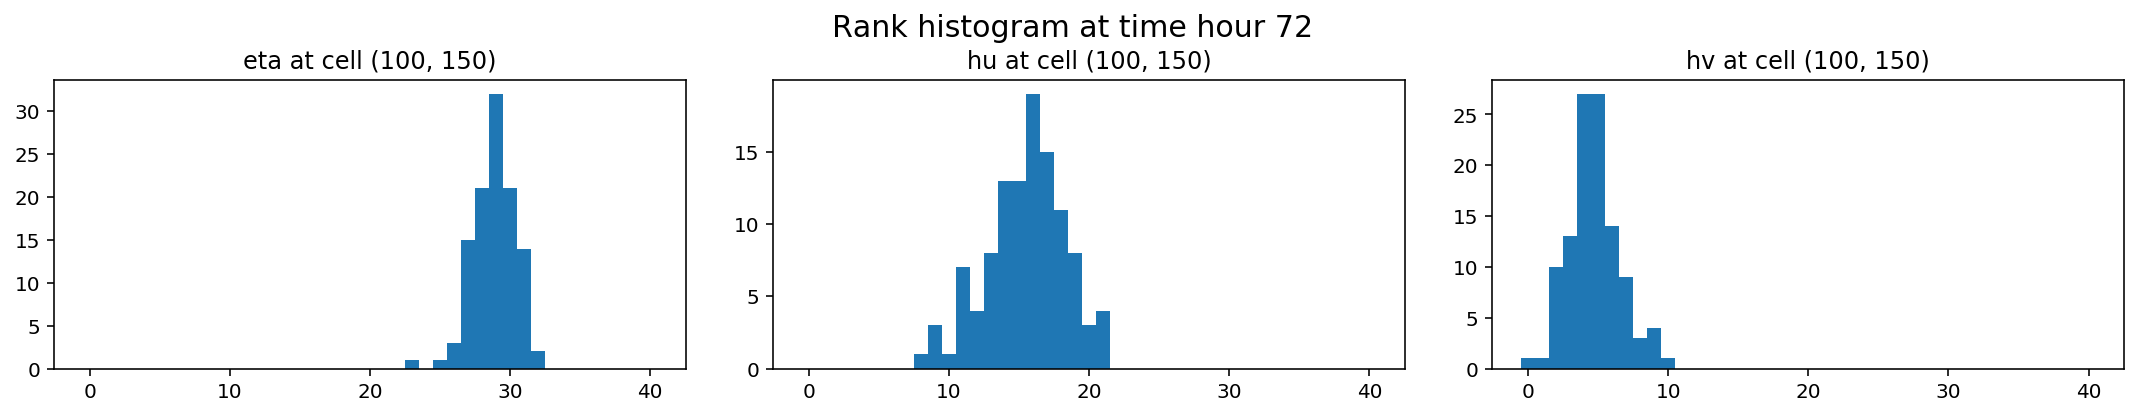

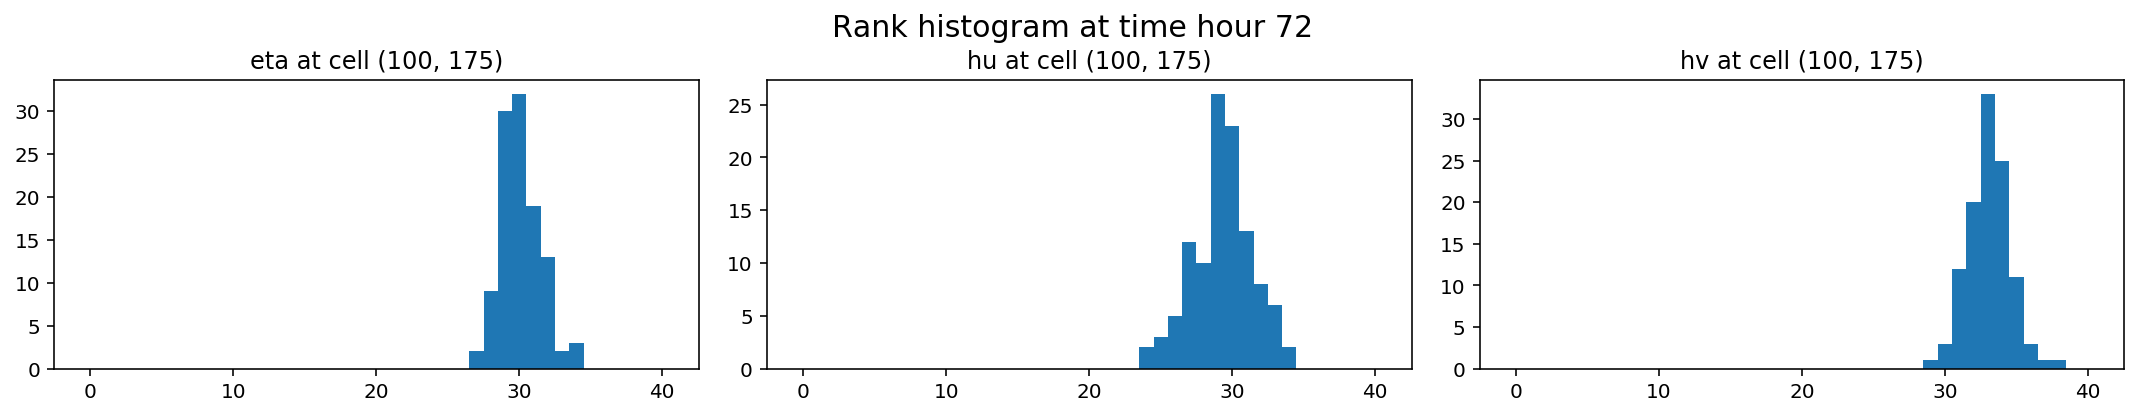

In [18]:

dataset = 'june_truth/rank_histogram_72_hour/'
dataset_path = os.path.join(media_dir, dataset)

hour = 72

interesting_y_indices = np.array([0, 25, 50, 70, 75, 80, 100, 125, 150, 175])

def rankhistogram(dataset_path, hour, truth_reader, interesting_y_indices, perturb=True):
    

    rank_histogram_paths = list(os.path.join(dataset_path, path) for path in os.listdir(dataset_path))
    #print(rank_histogram_paths)

    rank_histogram_files = []
    for path in rank_histogram_paths:
        rank_histogram_files.extend(file_filter(path, 
                                                ext='npz', 
                                                prefix='hour_' + str(hour).zfill(3)))

    print('Creating rank histogram from ' + str(len(rank_histogram_files)) + ' files')
    
    # Time in seconds is read from first file
    first_experiment = np.load(rank_histogram_files[0])
    t_rank = float(first_experiment['t'])
    
    # Index in the truth corresponding to the provided time
    t_rank_index = truth_time_step(t_rank)
    
    
    num_rank_experiments = len(rank_histogram_files)
    Ne = 40
    buoy_x = 100 # Index of buoy

    true_eta, true_hu, true_hv, true_t = truth_reader.getTimeStep(t_rank_index)
    ny = truth_reader.get('ny')

    buckets_hu  = np.zeros((ny, Ne+1))
    buckets_hv  = np.zeros((ny, Ne+1))
    buckets_eta = np.zeros((ny, Ne+1))

    interesting_y_indices = interesting_y_indices.astype(np.int32) # [0, 25, 50, 70, 75, 80, 100, 125, 150, 175]
    
    true_eta = true_eta[:,buoy_x]
    true_hu  = true_hu[:, buoy_x]
    true_hv  = true_hv[:, buoy_x]

    exp_no = 0
    for file in rank_histogram_files:
        result = np.load(file)
        eta = result['eta'] 
        hu  = result['hu']
        hv  = result['hv'] 
        t = result['t']
        assert(true_t == t)


        for y in interesting_y_indices:
            if perturb:
                ensemble_hu  = hu[y, :] + np.random.normal(scale=1, size=Ne)
                ensemble_hv  = hv[y, :] + np.random.normal(scale=1, size=Ne)
            else:
                ensemble_hu  = hu[y, :] 
                ensemble_hv  = hv[y, :] 
            ensemble_eta = eta[y, :] 

            ensemble_hu.sort()
            ensemble_hv.sort()
            ensemble_eta.sort()

            bucket_hu  = np.searchsorted(ensemble_hu, true_hu[y])
            bucket_hv  = np.searchsorted(ensemble_hv, true_hv[y])
            bucket_eta = np.searchsorted(ensemble_eta, true_eta[y])

            buckets_hu[y, bucket_hu] += 1
            buckets_hv[y, bucket_hv] += 1
            buckets_eta[y, bucket_eta] += 1

        if num_rank_experiments > 99:
            if (exp_no % int(num_rank_experiments/100) == 0):
                print('.'+str(exp_no)+'.', end='')
        exp_no += 1

    # Plot results
    for y in interesting_y_indices:

        fig, axs = plt.subplots(1, 3, figsize=(15,3))

        axs[0].bar(np.arange(Ne+1), buckets_eta[y,:], width=1)
        axs[0].set_title('eta at cell (100, '+str(y)+')')

        axs[1].bar(np.arange(Ne+1), buckets_hu[y,:], width=1)
        axs[1].set_title('hu at cell (100, '+str(y)+')')

        axs[2].bar(np.arange(Ne+1), buckets_hv[y,:], width=1)
        axs[2].set_title('hv at cell (100, '+str(y)+')')
        
        plt.suptitle('Rank histogram at time hour ' + str(hour), fontsize=15)
        #plt.tight_layout()
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    

rankhistogram(dataset_path, hour, truth_reader, interesting_y_indices, perturb=True)  
    

# Time development of rank histogram

Creating rank histogram from 148 files
.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..100..101..102..103..104..105..106..107..108..109..110..111..112..113..114..115..116..117..118..119..120..121..122..123..124..125..126..127..128..129..130..131..132..133..134..135..136..137..138..139..140..141..142..143..144..145..146..147.Creating rank histogram from 143 files
.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..7

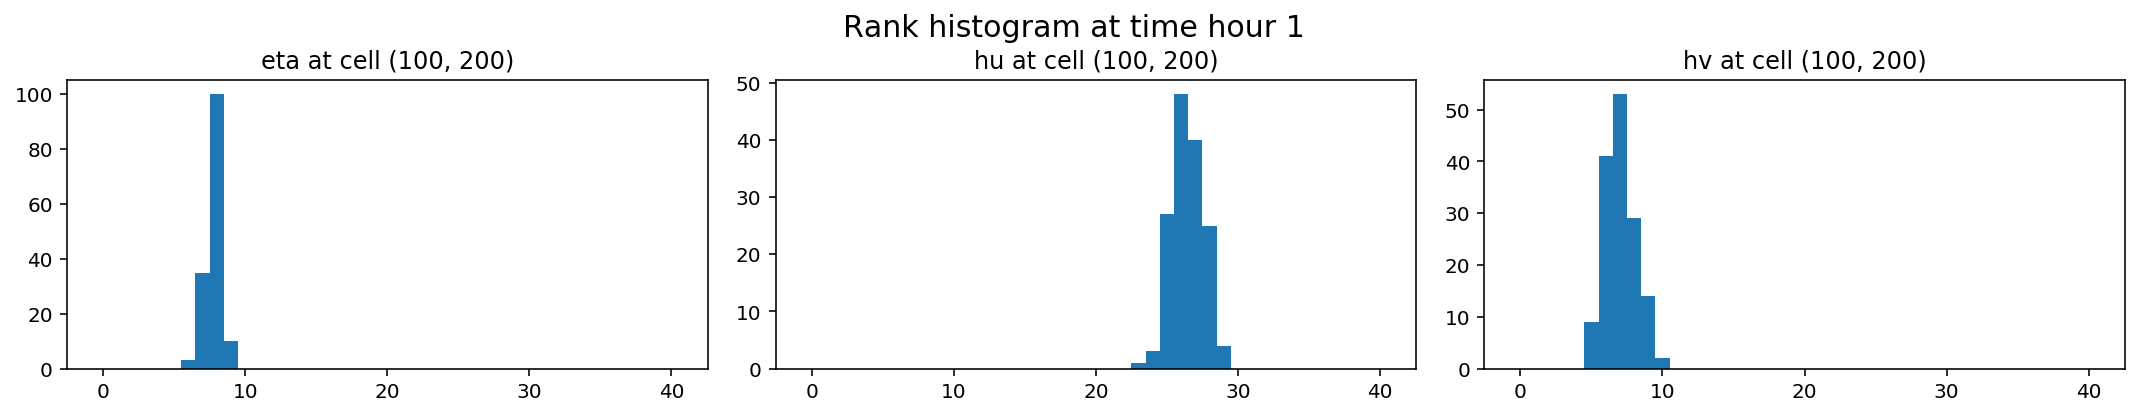

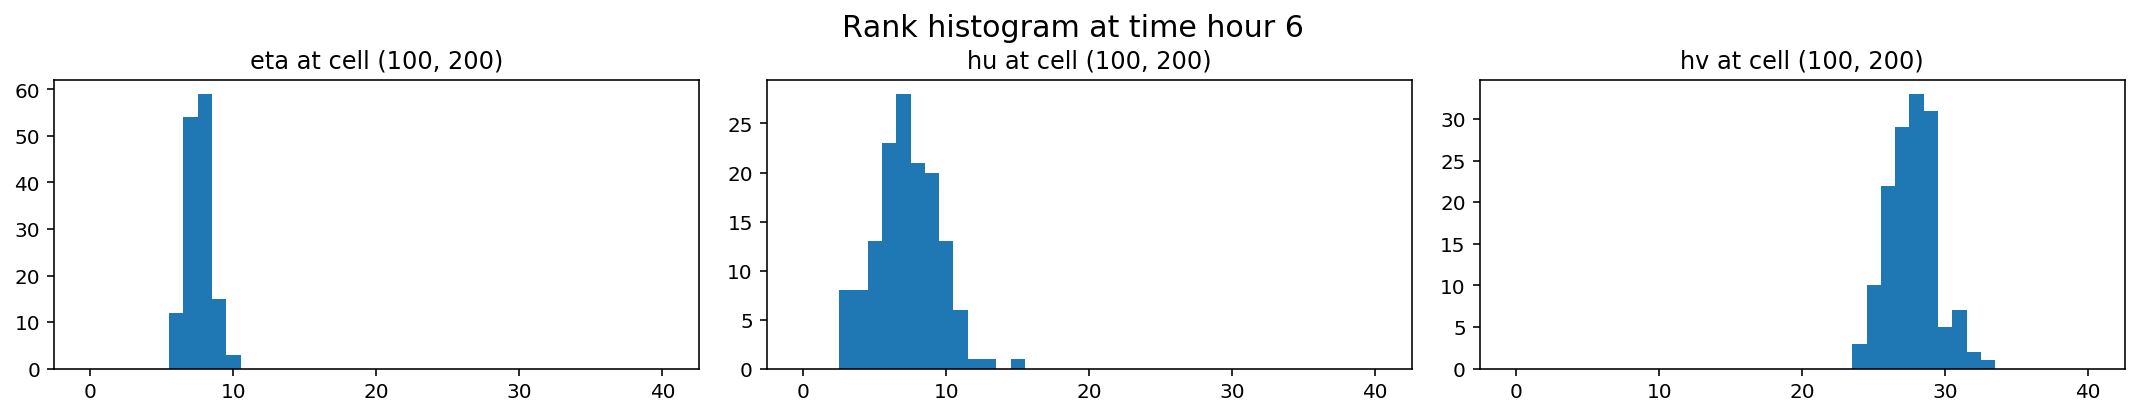

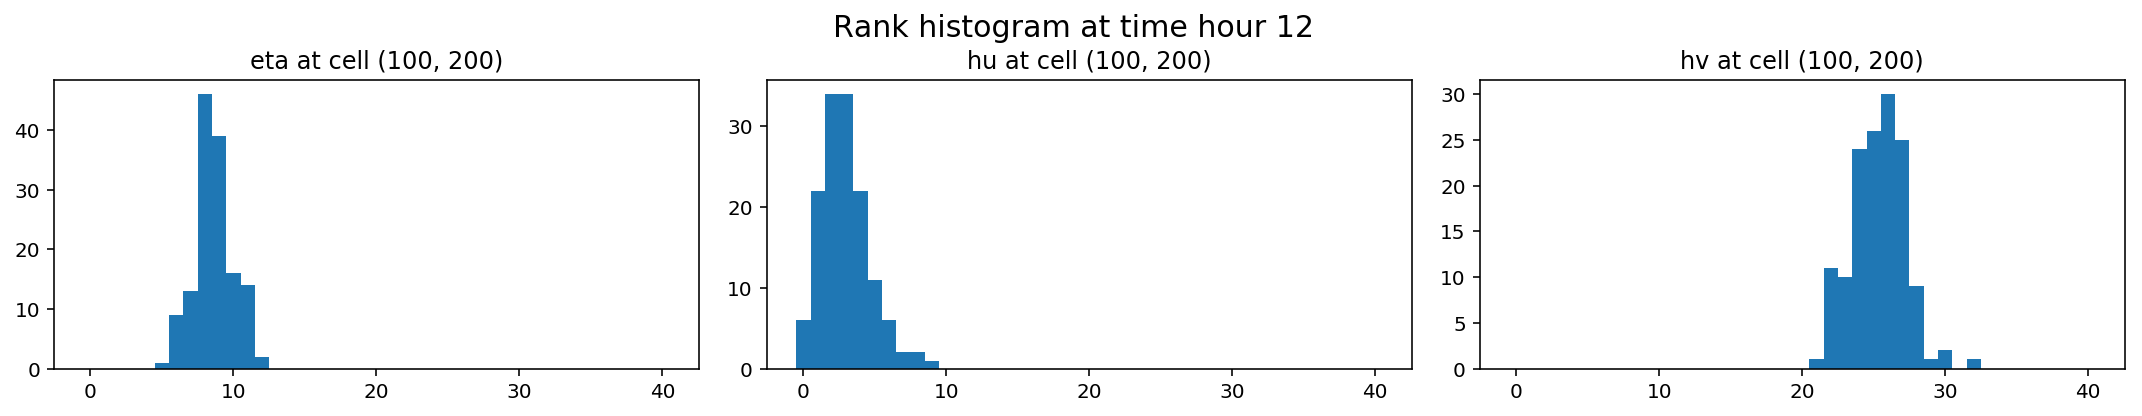

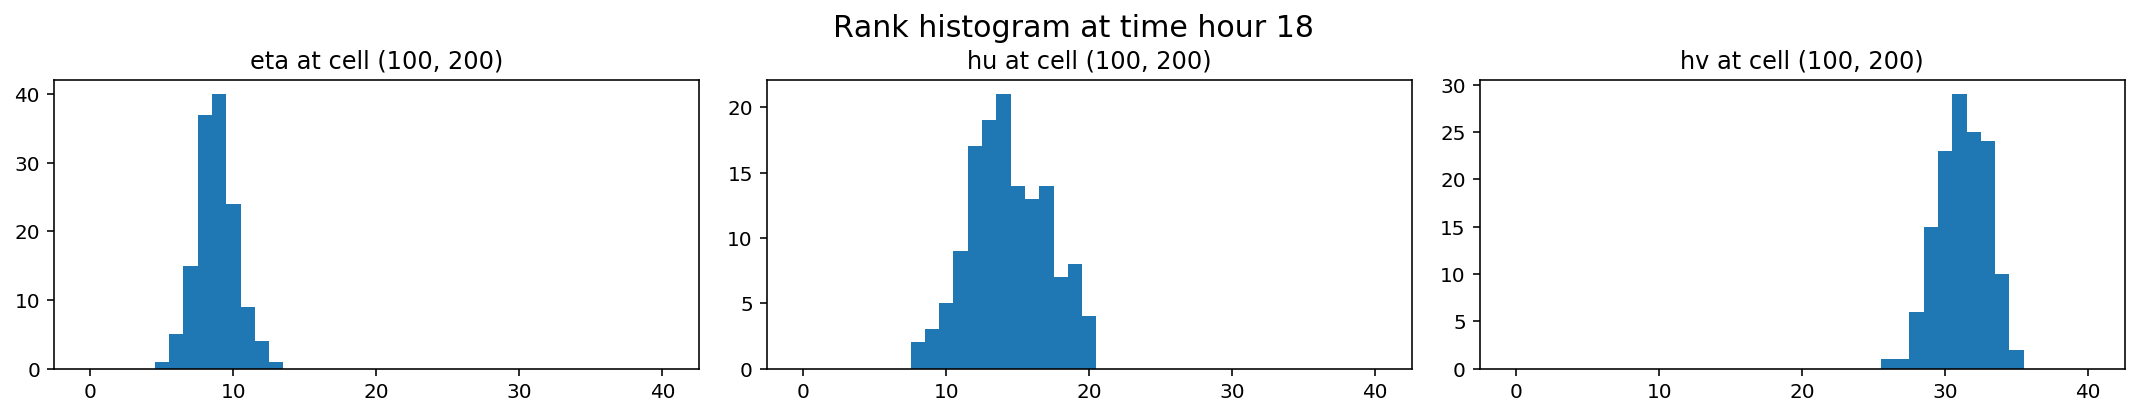

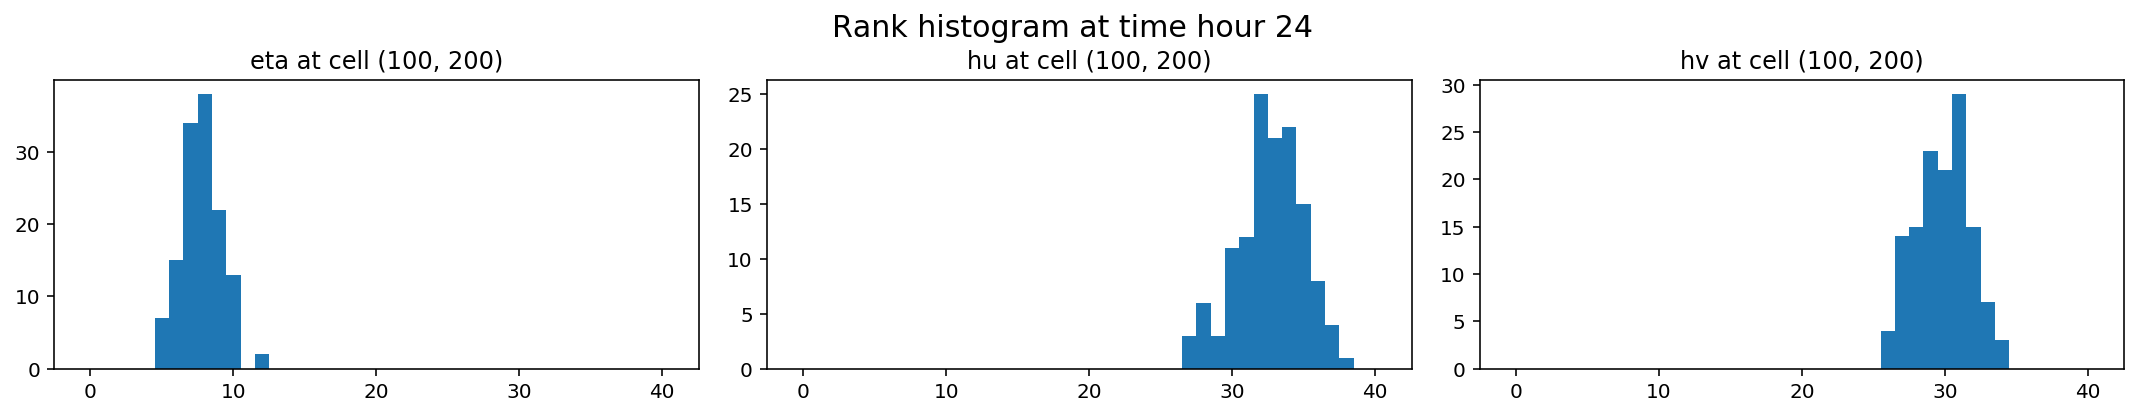

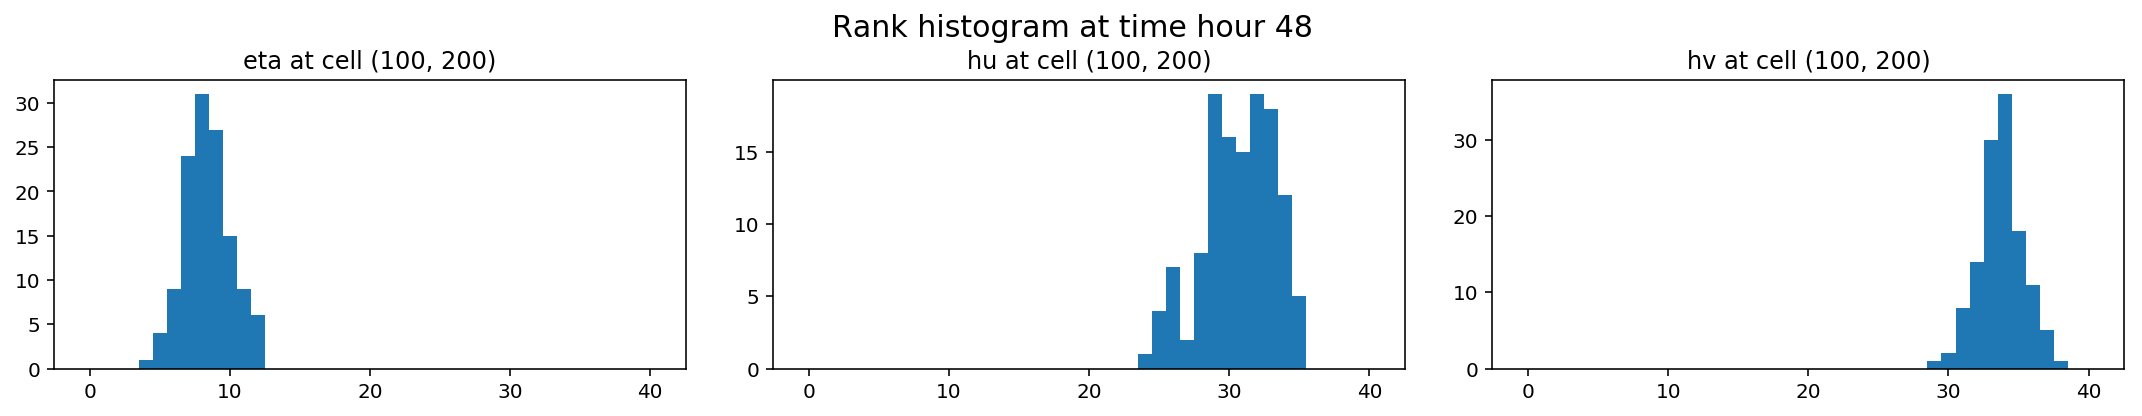

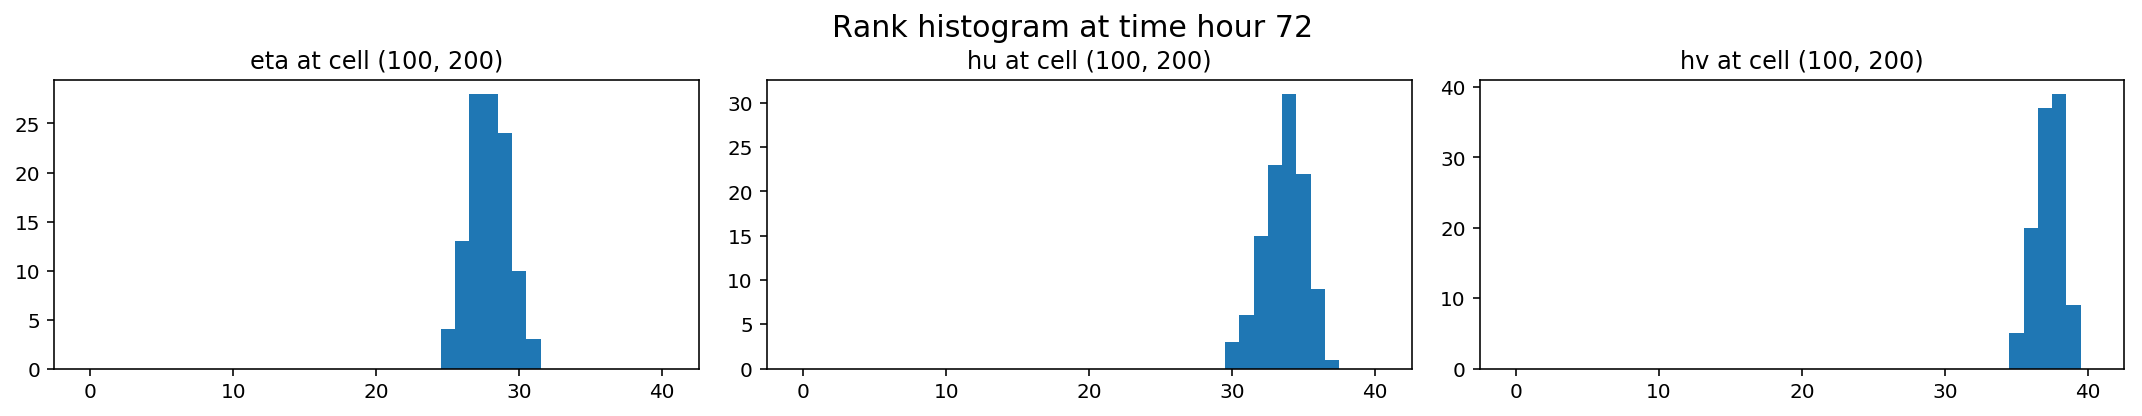

In [21]:

hours = np.array([1, 6, 12, 18, 24, 48, 72])
y = np.array([200])

for hour in hours:
    rankhistogram(dataset_path, hour, truth_reader, y, perturb=False)  




In [ ]:
print('time (in days) for 1000 rank histogram experiments')
print('40 west buoys', 37.5*24*1000/(60*60*24))
print('40 10-drifters', 19*24*1000/(60*60*24))
print('25 west buoys', 23*24*1000/(60*60*24))

In [ ]:
670 / 60, 37.5*24

In [ ]:
exp_24h = 670
exp_48h = exp_24h*2

num_days_100_exp_24 = exp_24h*100/(60*60*24)
print("100 experiments at 24 hours: ", num_days_100_exp_24)


time_until_monday_at_work = (8 + 24 + 24 + 24 + 8)*3600
num_24_hour_experiments_until_monday = time_until_monday_at_work/exp_24h
print('num_24_hour_experiments_until_monday', num_24_hour_experiments_until_monday)
num_48_hour_experiments_until_monday = time_until_monday_at_work/exp_48h
print('num_48_hour_experiments_until_monday', num_48_hour_experiments_until_monday)
